  # Neural Network Training for the MtM approach

In [225]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt 

plt.style.use('bmh')

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from tqdm import tqdm
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *
from MtM_training import *
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Create the neural network

In [226]:
def build_model(x,nr_neurons = 32):
    """
    Function that creates the neural network for the value function V
    """
    #Input Layer
    full_input = keras.Input(shape=(601,),name = "full_input")
    
#     # Reduction to the case wher ELGD,c and D is the same for all obligors
    small_input_1 = tf.reshape(full_input[:,0],(-1,1))
    small_input_2 = full_input[:,100:300]
    small_input_3 = tf.reshape(full_input[:,300],(-1,1))
    small_input_4 = full_input[:,400:500]
    small_input_5 = tf.reshape(full_input[:,500],(-1,1))
    small_input_6 = tf.reshape(full_input[:,600],(-1,1))
    # concatenate
    v = layers.concatenate([small_input_1,small_input_2,small_input_3,
                            small_input_4,small_input_5,small_input_6])
    Batch Normalization applied to the input
    v = layers.BatchNormalization()(v)

    # Create the NN
    v = layers.Dense(nr_neurons,activation = "relu")(v) #,kernel_regularizer=tf.keras.regularizers.L1(0.01))(v)
    # Create deep layers
    for i in range(5):
        v = layers.Dense(nr_neurons,activation =  "relu")(v) #,kernel_regularizer=tf.keras.regularizers.L1(0.01))(v)
    # Output Layers
    value_out = layers.Dense(1)(v)
    model = keras.Model(inputs=[full_input],outputs = [value_out])
    return model

### Load the Training Data

In [227]:
# # Read Data
def read_data(xpath,ypath):
    df_x = pd.read_csv(xpath, header=None)
    df_x = df_x.dropna()
    df_x = df_x.iloc[:,1:]

    df_y = pd.read_csv(ypath, header=None)
    df_y = df_y.dropna()
    df_y = df_y.iloc[:,1:]
    
    return df_x,df_y
x,y = read_data("csv/X_mtm_1.csv","csv/Y_mtm_1.csv")
for i in range(2,15):
    x_new,y_new = read_data("csv/X_mtm_"+str(i)+".csv","csv/Y_mtm_"+str(i)+".csv")
    x = pd.concat([x,x_new])
    y = pd.concat([y,y_new])
x_train = x.reset_index(drop = True)
y_train = y.reset_index(drop = True)

x_test, y_test = read_data("csv/X_mtm_test.csv","csv/Y_mtm_test.csv")

# Load the pretrained GA-Approx

In [228]:
x_train_approx = pd.read_csv("csv/X_Train_MtM_approx.csv", header=None).iloc[1:,1].reset_index(drop = True)
x_test_approx = pd.read_csv("csv/X_Test_MtM_approx.csv", header=None).iloc[1:,1]

Add to the training and test set, respectively

In [229]:
x_train = pd.concat([x_train,x_train_approx],axis = 1)
x_test = pd.concat([x_test,x_test_approx],axis = 1)

# Training of the neural network

In [231]:
# Train the model
EPOCHS = 10
neurons = 512
BATCH_SIZE = 32 # 32

In [222]:
model = build_model(x_train,neurons)

opt1 = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1=0.9, beta_2=0.999)
model.compile(loss=["mse",tf.keras.losses.MeanAbsolutePercentageError()],
              loss_weights=[1,0], # loss = 'mse', #loss=tf.keras.losses.MeanAbsolutePercentageError(), #mse',
                optimizer=opt1,
                metrics=['mae', 'mse'])
scaler = StandardScaler().fit(x_train)

In [249]:
joblib.dump(scaler, 'scaler_mtm.gz')
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# # Fit the Data
history = model.fit(x_train_scaled, y_train,  epochs=EPOCHS,batch_size = BATCH_SIZE,
                    validation_split = 0, verbose=1) #$,callbacks = [early_stop])


Epoch 1/10
439/439 [==============================] - 8s 18ms/step - loss: 2.4311e-06 - mae: 0.0010 - mse: 2.4311e-06
Epoch 2/10
439/439 [==============================] - 9s 20ms/step - loss: 1.4602e-06 - mae: 8.0468e-04 - mse: 1.4602e-06
Epoch 3/10
439/439 [==============================] - 9s 19ms/step - loss: 1.3352e-06 - mae: 7.6980e-04 - mse: 1.3352e-06
Epoch 4/10
439/439 [==============================] - 9s 20ms/step - loss: 1.3389e-06 - mae: 7.6899e-04 - mse: 1.3389e-06
Epoch 5/10
439/439 [==============================] - 9s 21ms/step - loss: 1.5842e-06 - mae: 8.2632e-04 - mse: 1.5842e-06
Epoch 6/10
439/439 [==============================] - 9s 20ms/step - loss: 1.6660e-06 - mae: 8.4852e-04 - mse: 1.6660e-06
Epoch 7/10
439/439 [==============================] - 9s 20ms/step - loss: 1.4421e-06 - mae: 8.0250e-04 - mse: 1.4421e-06
Epoch 8/10
439/439 [==============================] - 10s 22ms/step - loss: 1.5525e-06 - mae: 8.2872e-04 - mse: 1.5525e-06
Epoch 9/10
439/439 [=======

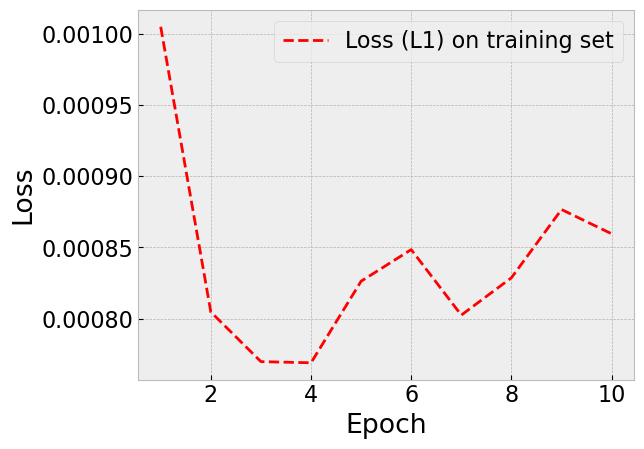

Prediction
1/1 [==============================] - 0s 47ms/step
[[0.02298596]
 [0.01819673]
 [0.02643447]
 [0.03701813]
 [0.01288744]]
True Values
            1
514  0.026470
54   0.018498
15   0.015206
586  0.036091
425  0.006913
32/32 [==============================] - 0s 5ms/step
Model Evaluation
32/32 - 0s - loss: 6.6887e-05 - mae: 0.0058 - mse: 6.6887e-05 - 173ms/epoch - 5ms/step
[6.688710709568113e-05, 0.00578577583655715, 6.688710709568113e-05]


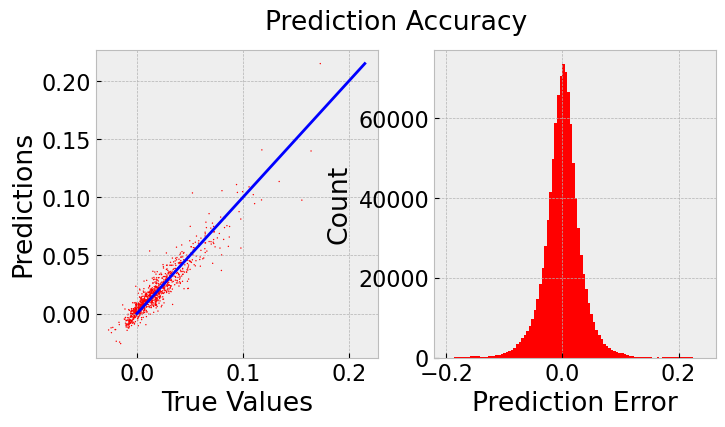

In [250]:
# Plot the training process
training_loss = history.history["mae"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")

#val_loss = history.history["val_mae"]
#plt.plot(epoch_count, val_loss, "b-")

plt.legend(["Loss (L1) on training set", "Loss (L1) on validation set"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.savefig('history_spot_many_options.eps', format='eps')
plt.show()

# Make a single Prediction
indices = [max(round(float(np.random.sample(1)*(len(x_test)-1))),0) for i in range(5)]
print("Prediction")
print(model.predict(x_test_scaled[indices]))
print("True Values")
print(y_test.iloc[indices])



# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
#Along a line
test_predictions = model.predict(x_test_scaled).flatten()
#a = plt.axes(aspect='equal')
axs[0].plot([0,max(test_predictions)],[0,max(test_predictions)],color = "blue")
axs[0].scatter(y_test, test_predictions, c='red',s=1, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')

# Histogram
error = np.array(model.predict(x_test_scaled).reshape(-1,) - np.array(y_test)).flatten()
axs[1].hist(error, bins = 100,color = 'red')
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy')
#plt.savefig('accuracy_spot_many_options.eps', format='eps')

# Model Evaluation
print("Model Evaluation")
print(model.evaluate(x_test_scaled, y_test, verbose=2))
# Percentage Error

Save the model

In [251]:
model.save("model_mtm_0999.h5")

### Compute GA approx on Test set

In [252]:
GA_List_999 = []
GA_List_small_999 = []
GA_approx_List_999 = []
GA_NN_List_999 = []
GA_approx_List_small_999 = []
GA_NN_List_small_999 = []


for i in range(len(x_test)):    
    GA_approx_List_999.append(x_test_approx.iloc[i])                
    GA_NN_List_999.append(model.predict(np.reshape(x_test_scaled[i,:],(1,601))))
    GA_List_999.append(y_test.iloc[i,:])                              
    N_obligors = np.sum(x_test.iloc[i,:100]>0)                            
    small_threshold = 25 # Set Threshold to 25 obligors
    if N_obligors < small_threshold:
        GA_List_small_999.append(GA_List_999[-1])
        GA_approx_List_small_999.append(GA_approx_List_999[-1])
        GA_NN_List_small_999.append(GA_NN_List_999[-1])     
        
GA_List_999 = [float(GA_List_999[i]) for i in range(len(GA_List_999))]
GA_List_small_999 = [float(GA_List_small_999[i]) for i in range(len(GA_List_small_999))]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 31ms/step


### Error of NN

In [253]:
diff_MC_NN_999 = np.array([np.abs(i[0]-j) for i,j in zip(GA_NN_List_999,GA_List_999)])
pd.DataFrame(diff_MC_NN_999).describe()

,0
count,1000.000000
mean,0.005786
std,0.005783
min,0.000010
25%,0.002040
50%,0.004282
75%,0.007580
max,0.058118


### Error of GA approx

In [254]:
diff_approx_exact_999 = np.array([np.abs(i-j) for i,j in zip(GA_List_999,GA_approx_List_999)])
pd.DataFrame(diff_approx_exact_999).describe()

,0
count,1000.000000
mean,0.010842
std,0.009172
min,0.000036
25%,0.003966
50%,0.008922
75%,0.015087
max,0.080297


### Error of NN on small portfolios

In [255]:
diff_MC_NN_small_999 = np.array([np.abs(i[0]-j) for i,j in zip(GA_NN_List_small_999,GA_List_small_999) ])
pd.DataFrame(diff_MC_NN_small_999).describe()

,0
count,184.000000
mean,0.009130
std,0.009083
min,0.000059
25%,0.003249
50%,0.006943
75%,0.011967
max,0.058118


### Error of GA approx on small portfolios

In [256]:
diff_approx_exact_small_999 = np.array([np.abs(i-j) for i,j in zip(GA_List_small_999,GA_approx_List_small_999)])
pd.DataFrame(diff_approx_exact_small_999).describe()

,0
count,184.000000
mean,0.015003
std,0.013102
min,0.000093
25%,0.005125
50%,0.012278
75%,0.020977
max,0.080297


### Plot the error of GA Approx

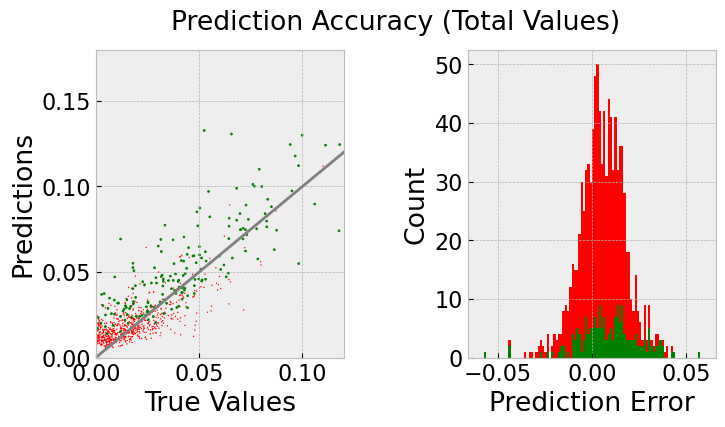

In [257]:
xmax = 0.12
xmin = -xmax
# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)
#Along a line
#a = plt.axes(aspect='equal')
axs[0].plot([0,xmax],[0,xmax],color = "gray") #,linestyle = "dashed")


axs[0].scatter(GA_List_999, GA_approx_List_999, c=['red']*len(GA_List_999),s=1, edgecolors='None')
axs[0].scatter(GA_List_small_999, GA_approx_List_small_999, c=['green']*len(GA_List_small_999),s=2) #, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')
axs[0].set_ylabel('Predictions')
axs[0].set_xlim([0,xmax])
axs[0].set_ylim([0,1.5*xmax])

# Histogram
error = np.array(GA_approx_List_999) - np.array(GA_List_999)
error_small = np.array(GA_approx_List_small_999) - np.array(GA_List_small_999)
axs[1].hist(error, bins = 100,color='red',range=[xmin*0.5,xmax*0.5])
axs[1].hist(error_small, bins = 100,color='green',range=[xmin*0.5,xmax*0.5])
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy (Total Values)')
plt.savefig('Plots/mtm_approx_0999.eps', format='eps',bbox_inches='tight')
plt.savefig('Plots/mtm_approx_0999.pdf', format='pdf',bbox_inches='tight')

### Plot the error of the NN

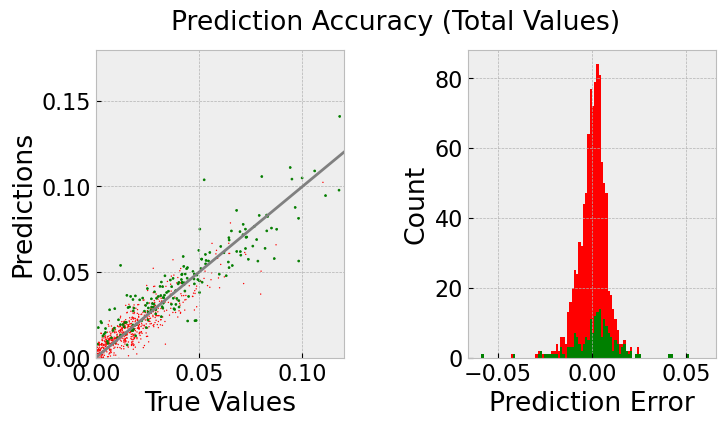

In [258]:
# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)
#Along a line
#a = plt.axes(aspect='equal')
axs[0].plot([0,xmax],[0,xmax],color = "gray") #,linestyle = "dashed")


axs[0].scatter(GA_List_999, GA_NN_List_999, c=['red']*len(GA_List_999),s=1, edgecolors='None')
axs[0].scatter(GA_List_small_999, GA_NN_List_small_999, c=['green']*len(GA_List_small_999),s=2) #, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')
axs[0].set_xlim([0,xmax])
axs[0].set_ylim([0,1.5*xmax])

# Histogram
error = np.array(GA_NN_List_999).flatten() - np.array(GA_List_999).flatten()
error_small = np.array(GA_NN_List_small_999).flatten() - np.array(GA_List_small_999).flatten()
axs[1].hist(error, bins = 100,color='red',range=[xmin*0.5,xmax*0.5])
axs[1].hist(error_small, bins = 100,color='green',range=[xmin*0.5,xmax*0.5])
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy (Total Values)')
plt.savefig('Plots/mtm_NN_0999.eps', format='eps',bbox_inches='tight')
plt.savefig('Plots/mtm_NN_0999.pdf', format='pdf',bbox_inches='tight')

### Produce Latex Table: Error on all portfolios

In [259]:
table_tex_1 = pd.concat([pd.DataFrame(diff_MC_NN_999).describe(),
                         pd.DataFrame(diff_approx_exact_999).describe()],axis = 1)
table_tex_1.columns = ['q = 99.9%,|GA NN - GA MC|',
                       'q = 99.9%, |GA Approx. - GA MC|']
#print(tabulate(table_tex_1, tablefmt="latex"))
print(table_tex_1.round(5).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  q = 99.9\%,|GA NN - GA MC| &  q = 99.9\%, |GA Approx. - GA MC| \\
\midrule
count &                 1000.00000 &                       1000.00000 \\
mean  &                    0.00579 &                          0.01084 \\
std   &                    0.00578 &                          0.00917 \\
min   &                    0.00001 &                          0.00004 \\
25\%   &                    0.00204 &                          0.00397 \\
50\%   &                    0.00428 &                          0.00892 \\
75\%   &                    0.00758 &                          0.01509 \\
max   &                    0.05812 &                          0.08030 \\
\bottomrule
\end{tabular}



C:\Users\jul_ses\AppData\Local\Temp\ipykernel_3504\4192034481.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_tex_1.round(5).to_latex())


### Produce Latex Table: Error on small portfolios

In [260]:
table_tex_2 = pd.concat([
                         pd.DataFrame(diff_MC_NN_small_999).describe(),
                         pd.DataFrame(diff_approx_exact_small_999).describe()],axis = 1)
table_tex_2.columns = ['%q = 99.9%,~|GA NN - GA MC|$',
                       '%q = 99.9%,~|GA Approx. - GA MC|$']
#print(tabulate(table_tex_2, tablefmt="latex"))
print(table_tex_2.round(5).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  \%q = 99.9\%,\textasciitilde |GA NN - GA MC|\$ &  \%q = 99.9\%,\textasciitilde |GA Approx. - GA MC|\$ \\
\midrule
count &                     184.00000 &                          184.00000 \\
mean  &                       0.00913 &                            0.01500 \\
std   &                       0.00908 &                            0.01310 \\
min   &                       0.00006 &                            0.00009 \\
25\%   &                       0.00325 &                            0.00512 \\
50\%   &                       0.00694 &                            0.01228 \\
75\%   &                       0.01197 &                            0.02098 \\
max   &                       0.05812 &                            0.08030 \\
\bottomrule
\end{tabular}



C:\Users\jul_ses\AppData\Local\Temp\ipykernel_3504\2257743522.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_tex_2.round(5).to_latex())
